<a href="https://colab.research.google.com/github/yuktachikate/Predicting-Like-A-Pilot-A-Deep-Learning-Framework-for-Socially-Aware-Aircraft-Trajectory-Prediction/blob/main/Predicting_Like_A_Pilot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
# Cell 1: Imports and Utility Functions
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [19]:
# Set device for training (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [22]:
# Set device for training (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Utility function: Forward Verlet Integration
def verlet_integration(last_two_positions, acc_pred, delta_t=1.0):
    """
    Uses forward Verlet integration to generate future positions.
    last_two_positions: (batch, num_agents, 2, 3) [x_{t-1}, x_t]
    acc_pred: (batch, num_agents, tpred, 3) predicted accelerations
    Returns:
        future_positions: (batch, num_agents, tpred, 3)
    """
    batch, num_agents, tpred, _ = acc_pred.size()
    positions = []
    x_prev = last_two_positions[:, :, 0, :]  # (batch, num_agents, 3)
    x_curr = last_two_positions[:, :, 1, :]  # (batch, num_agents, 3)
    for t in range(tpred):
        a_t = acc_pred[:, :, t, :]  # (batch, num_agents, 3)
        x_next = 2 * x_curr - x_prev + a_t * (delta_t ** 2)
        positions.append(x_next.unsqueeze(2))  # add time dimension
        x_prev, x_curr = x_curr, x_next
    future_positions = torch.cat(positions, dim=2)
    return future_positions

In [23]:
# Utility function: Dummy Data Generation for Extended Model
def get_dummy_extended_data(batch_size=2, num_agents=4, tobs=11, tpred=5):
    # Simulate observed trajectory: (batch, num_agents, tobs, 3)
    traj = torch.randn(batch_size, num_agents, tobs, 3)
    # Simulate weather data: (batch, num_agents, tobs, 2)
    weather = torch.randn(batch_size, num_agents, tobs, 2)
    # For integration, use the last two positions from the observed trajectory:
    last_two_positions = traj[:, :, -2:, :]  # (batch, num_agents, 2, 3)
    # Create a dummy ground truth future trajectory by integrating random accelerations
    true_acc = torch.randn(batch_size, num_agents, tpred, 3)
    true_future_positions = verlet_integration(last_two_positions, true_acc, delta_t=1.0)
    return traj, weather, last_two_positions, true_future_positions

In [24]:
# Utility function: Evaluation Metrics (ADE and FDE)
def compute_ADE_FDE(pred_positions, true_positions):
    # pred_positions, true_positions: (batch, num_agents, tpred, 3)
    ade = torch.mean(torch.norm(pred_positions - true_positions, dim=-1))
    fde = torch.mean(torch.norm(pred_positions[:, :, -1, :] - true_positions[:, :, -1, :], dim=-1))
    return ade.item(), fde.item()

In [5]:
# Conditional Variational Autoencoder (CVAE) Module
# ------------------------------
class CVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, output_dim):
        super(CVAE, self).__init__()
        # Encoder: maps input to latent parameters
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_logvar = nn.Linear(128, latent_dim)
        # Decoder: maps latent sample + condition back to output space
        self.fc2 = nn.Linear(latent_dim + input_dim, 128)
        self.fc3 = nn.Linear(128, output_dim)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        mu = self.fc_mu(h1)
        logvar = self.fc_logvar(h1)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, cond):
        # Concatenate the latent vector with the condition vector
        x = torch.cat([z, cond], dim=-1)
        h2 = F.relu(self.fc2(x))
        out = self.fc3(h2)
        return out

    def forward(self, x, cond):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        out = self.decode(z, cond)
        return out, mu, logvar

In [25]:
# Cell 2: Model Definitions

# TCN Encoder for Trajectory Encoding
class TCNEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=3):
        super(TCNEncoder, self).__init__()
        layers = []
        for i in range(num_layers):
            in_channels = input_dim if i == 0 else hidden_dim
            layers.append(nn.Conv1d(in_channels, hidden_dim, kernel_size=3, padding=1))
            layers.append(nn.ReLU())
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        # x: (batch*num_agents, tobs, features)
        x = x.transpose(1, 2)  # -> (batch*num_agents, features, tobs)
        x = self.network(x)
        x = x[:, :, -1]  # take the last time step -> (batch*num_agents, hidden_dim)
        return x

In [26]:
# CNN for Weather Encoding
class WeatherCNN(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(WeatherCNN, self).__init__()
        self.conv1 = nn.Conv1d(input_dim, hidden_dim, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=3, padding=1)

    def forward(self, x):
        # x: (batch*num_agents, tobs, features)
        x = x.transpose(1, 2)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x[:, :, -1]
        return x


In [27]:
# Simple Graph Attention Network (GAT)
class SimpleGAT(nn.Module):
    def __init__(self, in_features, out_features):
        super(SimpleGAT, self).__init__()
        self.fc = nn.Linear(in_features, out_features, bias=False)
        self.attn_fc = nn.Linear(2*out_features, 1, bias=False)

    def forward(self, x):
        # x: (batch, num_agents, features)
        batch, num_agents, _ = x.size()
        h = self.fc(x)  # (batch, num_agents, out_features)
        h_i = h.unsqueeze(2).repeat(1, 1, num_agents, 1)
        h_j = h.unsqueeze(1).repeat(1, num_agents, 1, 1)
        attn_input = torch.cat([h_i, h_j], dim=-1)  # (batch, num_agents, num_agents, 2*out_features)
        e = F.leaky_relu(self.attn_fc(attn_input)).squeeze(-1)  # (batch, num_agents, num_agents)
        alpha = F.softmax(e, dim=-1)
        h_prime = torch.bmm(alpha, h)  # (batch, num_agents, out_features)
        return h_prime

In [28]:

# Conditional Variational Autoencoder (CVAE)
class CVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, output_dim):
        super(CVAE, self).__init__()
        # Encoder: maps input to latent parameters
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_logvar = nn.Linear(128, latent_dim)
        # Decoder: maps latent sample + condition back to output
        self.fc2 = nn.Linear(latent_dim + input_dim, 128)
        self.fc3 = nn.Linear(128, output_dim)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        mu = self.fc_mu(h1)
        logvar = self.fc_logvar(h1)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, cond):
        x = torch.cat([z, cond], dim=-1)
        h2 = F.relu(self.fc2(x))
        out = self.fc3(h2)
        return out

    def forward(self, x, cond):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        out = self.decode(z, cond)
        return out, mu, logvar

In [29]:

# Extended TrajAirNet for Multi-Step Prediction
class ExtendedTrajAirNet(nn.Module):
    def __init__(self, traj_input_dim=3, weather_input_dim=2, hidden_dim=64, latent_dim=16, tpred=5):
        """
        tpred: number of future time steps to predict
        """
        super(ExtendedTrajAirNet, self).__init__()
        self.tpred = tpred
        self.tcn_encoder = TCNEncoder(traj_input_dim, hidden_dim)
        self.weather_cnn = WeatherCNN(weather_input_dim, hidden_dim)
        self.gat = SimpleGAT(hidden_dim * 2, hidden_dim)
        # CVAE outputs tpred * 3 values (acceleration for each future step)
        self.cvae = CVAE(input_dim=hidden_dim*2, latent_dim=latent_dim, output_dim=tpred * 3)

    def forward(self, traj, weather):
        """
        traj: (batch, num_agents, tobs, 3)
        weather: (batch, num_agents, tobs, 2)
        """
        batch, num_agents, tobs, _ = traj.size()
        traj = traj.view(batch * num_agents, tobs, -1)
        weather = weather.view(batch * num_agents, tobs, -1)
        traj_feat = self.tcn_encoder(traj)         # (batch*num_agents, hidden_dim)
        weather_feat = self.weather_cnn(weather)     # (batch*num_agents, hidden_dim)
        combined_feat = torch.cat([traj_feat, weather_feat], dim=-1)  # (batch*num_agents, hidden_dim*2)
        combined_feat = combined_feat.view(batch, num_agents, -1)
        gat_feat = self.gat(combined_feat)  # Social context (optional for further processing)
        # Use combined features as condition for CVAE
        cond_feat = combined_feat.view(batch * num_agents, -1)
        # CVAE predicts future accelerations: (batch*num_agents, tpred*3)
        acc_pred_flat, mu, logvar = self.cvae(cond_feat, cond_feat)
        # Reshape to (batch, num_agents, tpred, 3)
        acc_pred = acc_pred_flat.view(batch, num_agents, self.tpred, 3)
        return acc_pred, mu, logvar

# How It Works
## Data Encoding:

TCNEncoder: Encodes the observed 3D trajectories (over a fixed observation window) to capture temporal dynamics.
WeatherCNN: Processes the weather context (e.g., wind data) over the same observation period.
Their outputs are concatenated to form a combined feature representation for each agent.

### Social Context via GAT:

A simple Graph Attention Network (GAT) computes attention scores between agents to account for inter-agent interactions.


### Multi-Future Prediction using CVAE:

The CVAE module encodes the uncertainty in future accelerations. During training, the model minimizes the MSE between predicted and target accelerations along with a KL divergence regularizer.


### Training:

The training loop demonstrates how to train the model on dummy data. In a full implementation, you would replace the dummy data with your preprocessed TrajAir dataset.

This code provides a prototype of the TrajAirNet pipeline and can be expanded to incorporate full multi-step trajectory prediction (using, for example, forward Verlet integration) and other advanced components as described in the paper.

In [30]:
# Extended loss function: Position MSE + KL Divergence
def extended_loss_function(pred_positions, true_positions, mu, logvar):
    """
    pred_positions & true_positions: (batch, num_agents, tpred, 3)
    """
    mse_loss = F.mse_loss(pred_positions, true_positions, reduction='mean')
    kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return mse_loss + kl_loss, mse_loss, kl_loss

In [31]:
# Training function for ExtendedTrajAirNet
def train_extended_model(model, optimizer, epochs=100):
    model.train()
    loss_history = []
    ade_history = []
    fde_history = []
    for epoch in range(epochs):
        traj, weather, last_two_positions, true_future_positions = get_dummy_extended_data()
        traj = traj.to(device)
        weather = weather.to(device)
        last_two_positions = last_two_positions.to(device)
        true_future_positions = true_future_positions.to(device)

        optimizer.zero_grad()
        acc_pred, mu, logvar = model(traj, weather)
        # Integrate accelerations to obtain predicted positions
        pred_positions = verlet_integration(last_two_positions, acc_pred, delta_t=1.0)
        loss, mse_loss, kl_loss = extended_loss_function(pred_positions, true_future_positions, mu, logvar)
        loss.backward()
        optimizer.step()

        loss_history.append(loss.item())
        ade, fde = compute_ADE_FDE(pred_positions, true_future_positions)
        ade_history.append(ade)
        fde_history.append(fde)
        if epoch % 10 == 0:
            print(f"Epoch {epoch}: Loss={loss.item():.4f}, MSE={mse_loss.item():.4f}, KL={kl_loss.item():.4f}, ADE={ade:.4f}, FDE={fde:.4f}")
    return loss_history, ade_history, fde_history


In [37]:
# Cell 4: Instantiate the Model and Optimizer
model_ext = ExtendedTrajAirNet(tpred=10).to(device)
optimizer_ext = optim.Adam(model_ext.parameters(), lr=1e-4)

In [39]:
def train_extended_model(model, optimizer, epochs=100):
    model.train()
    loss_history = []
    ade_history = []
    fde_history = []
    for epoch in range(epochs):
        # Ensure dummy data uses the same tpred as the model
        traj, weather, last_two_positions, true_future_positions = get_dummy_extended_data(tpred=model.tpred)
        traj = traj.to(device)
        weather = weather.to(device)
        last_two_positions = last_two_positions.to(device)
        true_future_positions = true_future_positions.to(device)

        optimizer.zero_grad()
        acc_pred, mu, logvar = model(traj, weather)
        # Integrate accelerations to obtain predicted positions
        pred_positions = verlet_integration(last_two_positions, acc_pred, delta_t=1.0)
        loss, mse_loss, kl_loss = extended_loss_function(pred_positions, true_future_positions, mu, logvar)
        loss.backward()
        optimizer.step()

        loss_history.append(loss.item())
        ade, fde = compute_ADE_FDE(pred_positions, true_future_positions)
        ade_history.append(ade)
        fde_history.append(fde)
        if epoch % 10 == 0:
            print(f"Epoch {epoch}: Loss={loss.item():.4f}, MSE={mse_loss.item():.4f}, KL={kl_loss.item():.4f}, ADE={ade:.4f}, FDE={fde:.4f}")
    return loss_history, ade_history, fde_history



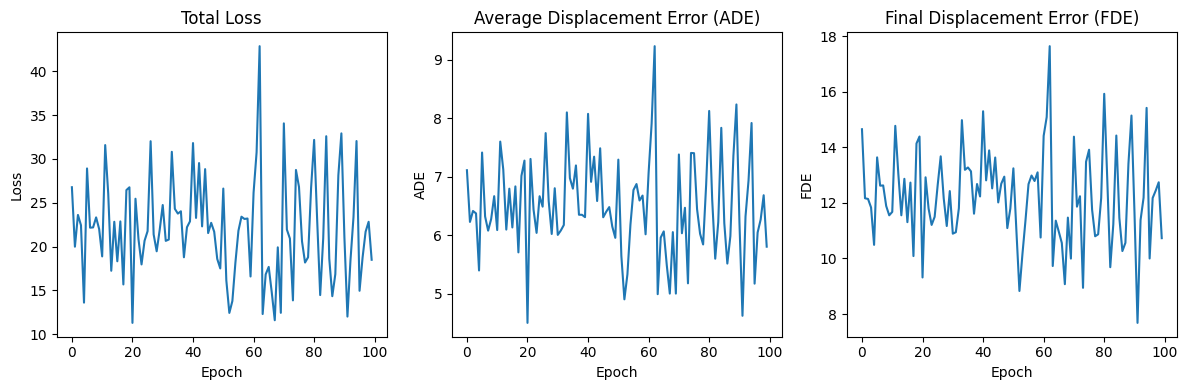

In [35]:
# Cell 6: Plot Training Curves: Loss, ADE, and FDE
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(loss_history)
plt.title("Total Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 3, 2)
plt.plot(ade_history)
plt.title("Average Displacement Error (ADE)")
plt.xlabel("Epoch")
plt.ylabel("ADE")

plt.subplot(1, 3, 3)
plt.plot(fde_history)
plt.title("Final Displacement Error (FDE)")
plt.xlabel("Epoch")
plt.ylabel("FDE")

plt.tight_layout()
plt.show()



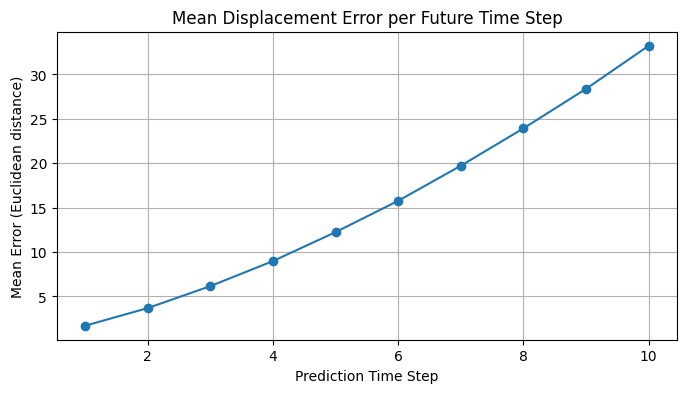

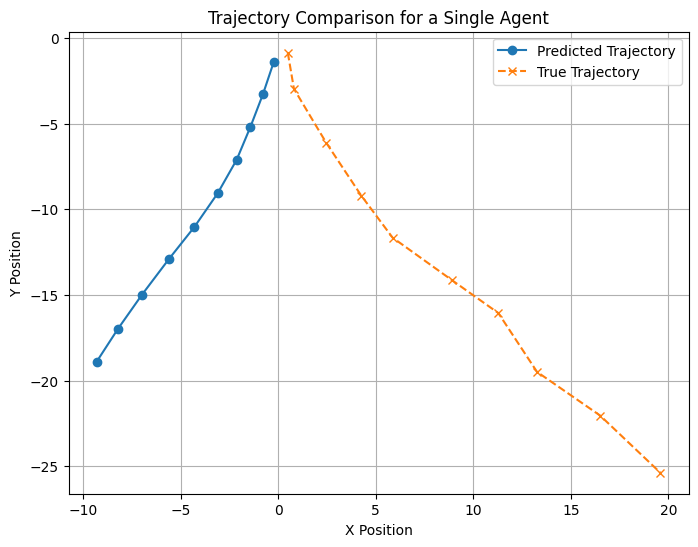

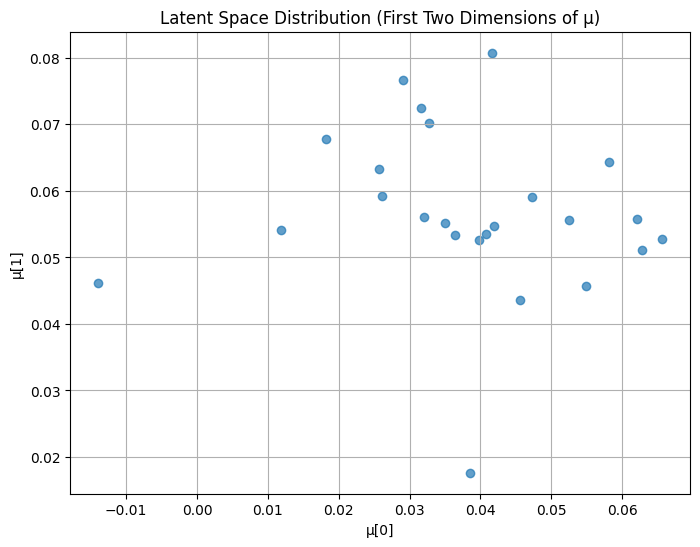

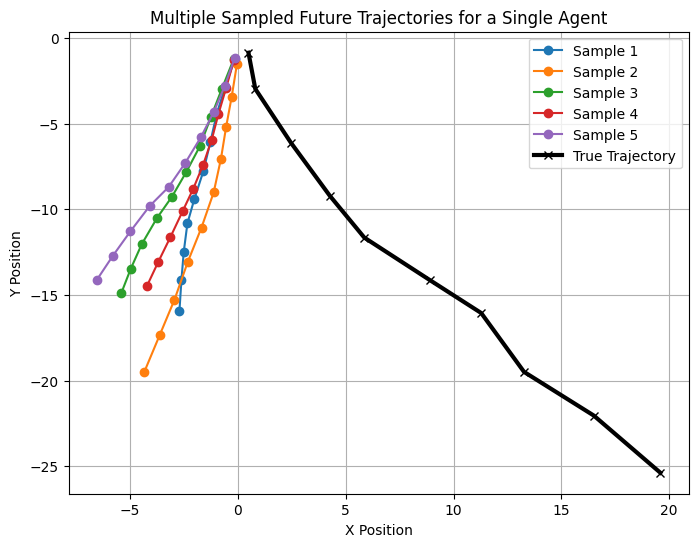

In [40]:
# Cell 7: Further Analysis and Visualization

# Set the model to evaluation mode
model_ext.eval()

# Generate a batch of dummy data for analysis
batch_size = 8
num_agents = 3
tobs = 11
tpred = 10  # Using a longer prediction horizon for analysis
traj, weather, last_two_positions, true_future_positions = get_dummy_extended_data(batch_size=batch_size,
                                                                                    num_agents=num_agents,
                                                                                    tobs=tobs,
                                                                                    tpred=tpred)
traj = traj.to(device)
weather = weather.to(device)
last_two_positions = last_two_positions.to(device)
true_future_positions = true_future_positions.to(device)

with torch.no_grad():
    acc_pred, mu, logvar = model_ext(traj, weather)
    # Integrate accelerations to get predicted positions
    pred_positions = verlet_integration(last_two_positions, acc_pred, delta_t=1.0)

# 1. Compute and Plot Mean Displacement Error per Future Time Step
errors_per_timestep = []
for t in range(tpred):
    error_t = torch.norm(pred_positions[:, :, t, :] - true_future_positions[:, :, t, :], dim=-1)
    mean_error_t = error_t.mean().item()
    errors_per_timestep.append(mean_error_t)

plt.figure(figsize=(8, 4))
plt.plot(np.arange(1, tpred + 1), errors_per_timestep, marker='o')
plt.title("Mean Displacement Error per Future Time Step")
plt.xlabel("Prediction Time Step")
plt.ylabel("Mean Error (Euclidean distance)")
plt.grid(True)
plt.show()

# 2. Plot Example Trajectories for a Single Agent
sample_idx = 0
agent_idx = 0
pred_traj = pred_positions[sample_idx, agent_idx].cpu().numpy()  # (tpred, 3)
true_traj = true_future_positions[sample_idx, agent_idx].cpu().numpy()  # (tpred, 3)

plt.figure(figsize=(8, 6))
plt.plot(pred_traj[:, 0], pred_traj[:, 1], marker='o', label='Predicted Trajectory')
plt.plot(true_traj[:, 0], true_traj[:, 1], marker='x', linestyle='--', label='True Trajectory')
plt.title("Trajectory Comparison for a Single Agent")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.legend()
plt.grid(True)
plt.show()

# 3. Latent Space Analysis: Scatter Plot of μ (First Two Dimensions)
mu_np = mu.cpu().numpy()
plt.figure(figsize=(8, 6))
plt.scatter(mu_np[:, 0], mu_np[:, 1], alpha=0.7)
plt.title("Latent Space Distribution (First Two Dimensions of μ)")
plt.xlabel("μ[0]")
plt.ylabel("μ[1]")
plt.grid(True)
plt.show()

# 4. Sampling Multiple Future Trajectories to Visualize Uncertainty
num_samples = 5
sampled_trajs = []

with torch.no_grad():
    for i in range(num_samples):
        acc_pred_sample, _, _ = model_ext(traj, weather)
        pred_positions_sample = verlet_integration(last_two_positions, acc_pred_sample, delta_t=1.0)
        sampled_trajs.append(pred_positions_sample[sample_idx, agent_idx].cpu().numpy())

plt.figure(figsize=(8, 6))
for i, traj_sample in enumerate(sampled_trajs):
    plt.plot(traj_sample[:, 0], traj_sample[:, 1], marker='o', label=f"Sample {i+1}")
plt.plot(true_traj[:, 0], true_traj[:, 1], marker='x', linewidth=3, color='black', label='True Trajectory')
plt.title("Multiple Sampled Future Trajectories for a Single Agent")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.legend()
plt.grid(True)
plt.show()


# Experiment Tracking with TensorBoard

In [41]:
# Cell 8: Experiment Tracking with TensorBoard
from torch.utils.tensorboard import SummaryWriter
import time

# Create a log directory with a timestamp
log_dir = f"runs/extended_trajair_{time.strftime('%Y%m%d-%H%M%S')}"
writer = SummaryWriter(log_dir)

def train_with_tensorboard(model, optimizer, epochs=100):
    model.train()
    for epoch in range(epochs):
        # Generate dummy data using the same prediction horizon as the model
        traj, weather, last_two_positions, true_future_positions = get_dummy_extended_data(tpred=model.tpred)
        traj = traj.to(device)
        weather = weather.to(device)
        last_two_positions = last_two_positions.to(device)
        true_future_positions = true_future_positions.to(device)

        optimizer.zero_grad()
        acc_pred, mu, logvar = model(traj, weather)
        pred_positions = verlet_integration(last_two_positions, acc_pred, delta_t=1.0)
        loss, mse_loss, kl_loss = extended_loss_function(pred_positions, true_future_positions, mu, logvar)
        loss.backward()
        optimizer.step()

        ade, fde = compute_ADE_FDE(pred_positions, true_future_positions)

        # Log metrics
        writer.add_scalar("Loss/Total", loss.item(), epoch)
        writer.add_scalar("Loss/MSE", mse_loss.item(), epoch)
        writer.add_scalar("Loss/KL", kl_loss.item(), epoch)
        writer.add_scalar("Metric/ADE", ade, epoch)
        writer.add_scalar("Metric/FDE", fde, epoch)

        if epoch % 10 == 0:
            print(f"Epoch {epoch}: Loss={loss.item():.4f}, MSE={mse_loss.item():.4f}, KL={kl_loss.item():.4f}, ADE={ade:.4f}, FDE={fde:.4f}")
    writer.close()

# To run training with TensorBoard logging, call:
# train_with_tensorboard(model_ext, optimizer_ext, epochs=100)


# Hyperparameter Optimization with Optuna

In [43]:
# Cell 9: Hyperparameter Optimization with Optuna
!pip install optuna

import optuna

def objective(trial):
    # Suggest hyperparameters
    hidden_dim = trial.suggest_categorical("hidden_dim", [32, 64, 128])
    latent_dim = trial.suggest_categorical("latent_dim", [8, 16, 32])
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-3)

    # Instantiate a new model with these hyperparameters and tpred=10 (for example)
    model = ExtendedTrajAirNet(traj_input_dim=3, weather_input_dim=2, hidden_dim=hidden_dim, latent_dim=latent_dim, tpred=10).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Train for a limited number of epochs for speed
    num_epochs = 20
    total_loss = 0.0
    for epoch in range(num_epochs):
        traj, weather, last_two_positions, true_future_positions = get_dummy_extended_data(tpred=model.tpred)
        traj = traj.to(device)
        weather = weather.to(device)
        last_two_positions = last_two_positions.to(device)
        true_future_positions = true_future_positions.to(device)

        optimizer.zero_grad()
        acc_pred, mu, logvar = model(traj, weather)
        pred_positions = verlet_integration(last_two_positions, acc_pred, delta_t=1.0)
        loss, _, _ = extended_loss_function(pred_positions, true_future_positions, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / num_epochs
    return avg_loss

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)

print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")


[I 2025-03-21 23:25:52,776] A new study created in memory with name: no-name-565b58b7-3a57-4546-892c-e5f1ecdd1e15
<ipython-input-43-57d6177bf364>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-3)
[I 2025-03-21 23:25:52,965] Trial 0 finished with value: 120.30353622436523 and parameters: {'hidden_dim': 32, 'latent_dim': 16, 'lr': 3.199030711866082e-05}. Best is trial 0 with value: 120.30353622436523.
[I 2025-03-21 23:25:53,159] Trial 1 finished with value: 108.99380912780762 and parameters: {'hidden_dim': 64, 'latent_dim': 32, 'lr': 9.632489582356395e-05}. Best is trial 1 with value: 108.99380912780762.
[I 2025-03-21 23:25:53,469] Trial 2 finished with value: 110.46208782196045 and parameters: {'hidden_dim': 128, 'latent_dim': 16, 'lr': 2.7675674742639435e-05}. Best is trial 1 with

Best trial:
  Value:  108.99380912780762
  Params: 
    hidden_dim: 64
    latent_dim: 32
    lr: 9.632489582356395e-05


# Monte Carlo Dropout Inference for Uncertainty Quantification

In [44]:
# Cell 10: Monte Carlo Dropout Inference for Uncertainty Quantification
def mc_dropout_inference(model, traj, weather, last_two_positions, num_samples=10, delta_t=1.0):
    model.train()  # Keep dropout active
    predictions = []
    for i in range(num_samples):
        acc_pred, _, _ = model(traj, weather)
        pred_positions = verlet_integration(last_two_positions, acc_pred, delta_t=delta_t)
        predictions.append(pred_positions.unsqueeze(0))
    predictions = torch.cat(predictions, dim=0)  # Shape: (num_samples, batch, num_agents, tpred, 3)
    return predictions

# Example usage:
model_ext.train()  # Ensure dropout is active (if you have dropout layers)
traj, weather, last_two_positions, _ = get_dummy_extended_data(batch_size=4, num_agents=3, tobs=11, tpred=model_ext.tpred)
traj = traj.to(device)
weather = weather.to(device)
last_two_positions = last_two_positions.to(device)

pred_samples = mc_dropout_inference(model_ext, traj, weather, last_two_positions, num_samples=10)
# For one sample and one agent:
sample_idx = 0
agent_idx = 0
predictions_for_agent = pred_samples[:, sample_idx, agent_idx, :, :]  # (num_samples, tpred, 3)
mean_prediction = predictions_for_agent.mean(dim=0)
std_prediction = predictions_for_agent.std(dim=0)

print("Mean Prediction for agent:", mean_prediction)
print("Std Dev for agent:", std_prediction)


Mean Prediction for agent: tensor([[ 2.8900,  2.4956,  1.0337],
        [ 5.1128,  3.6326,  1.8795],
        [ 7.3880,  4.8203,  2.7673],
        [ 9.6728,  6.0211,  3.6890],
        [11.8105,  7.2783,  4.6400],
        [13.8657,  8.6006,  5.4295],
        [15.9210,  9.9959,  6.2104],
        [18.0301, 11.1934,  7.0603],
        [20.1316, 12.4651,  7.8516],
        [22.2774, 13.7116,  8.7281]], grad_fn=<MeanBackward1>)
Std Dev for agent: tensor([[0.0753, 0.0539, 0.0721],
        [0.1889, 0.1675, 0.1422],
        [0.2989, 0.2838, 0.1982],
        [0.3624, 0.3799, 0.2516],
        [0.4447, 0.4975, 0.2991],
        [0.5380, 0.6605, 0.3604],
        [0.6859, 0.8138, 0.4579],
        [0.8693, 0.9583, 0.5681],
        [1.0325, 1.1299, 0.7216],
        [1.2193, 1.3103, 0.9109]], grad_fn=<StdBackward0>)


# Use t-SNE (from scikit-learn) to reduce the dimensionality of your latent vectors for visualization.

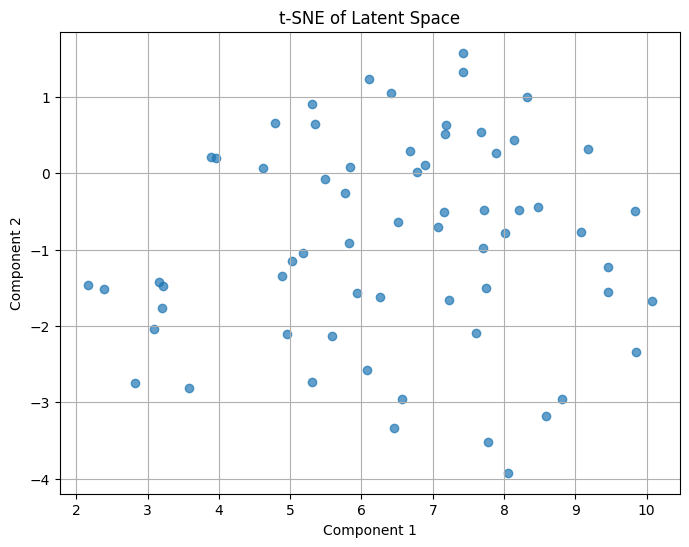

In [45]:
# Cell 11: t-SNE Visualization of Latent Space
from sklearn.manifold import TSNE

model_ext.eval()
with torch.no_grad():
    traj, weather, _, _ = get_dummy_extended_data(batch_size=16, num_agents=4, tobs=11, tpred=model_ext.tpred)
    traj = traj.to(device)
    weather = weather.to(device)
    # Forward pass to get the latent vectors (mu)
    _, mu, _ = model_ext(traj, weather)
    # mu shape: (batch*num_agents, latent_dim)
    mu_np = mu.cpu().numpy()

tsne = TSNE(n_components=2, random_state=42)
mu_tsne = tsne.fit_transform(mu_np)

plt.figure(figsize=(8, 6))
plt.scatter(mu_tsne[:, 0], mu_tsne[:, 1], alpha=0.7)
plt.title("t-SNE of Latent Space")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.show()


Final Training Metrics Summary:
                 Metric      Value
0            Final Loss  18.491589
1             Final ADE   5.802395
2             Final FDE  10.730041
3  Mean Time-step Error  15.379550


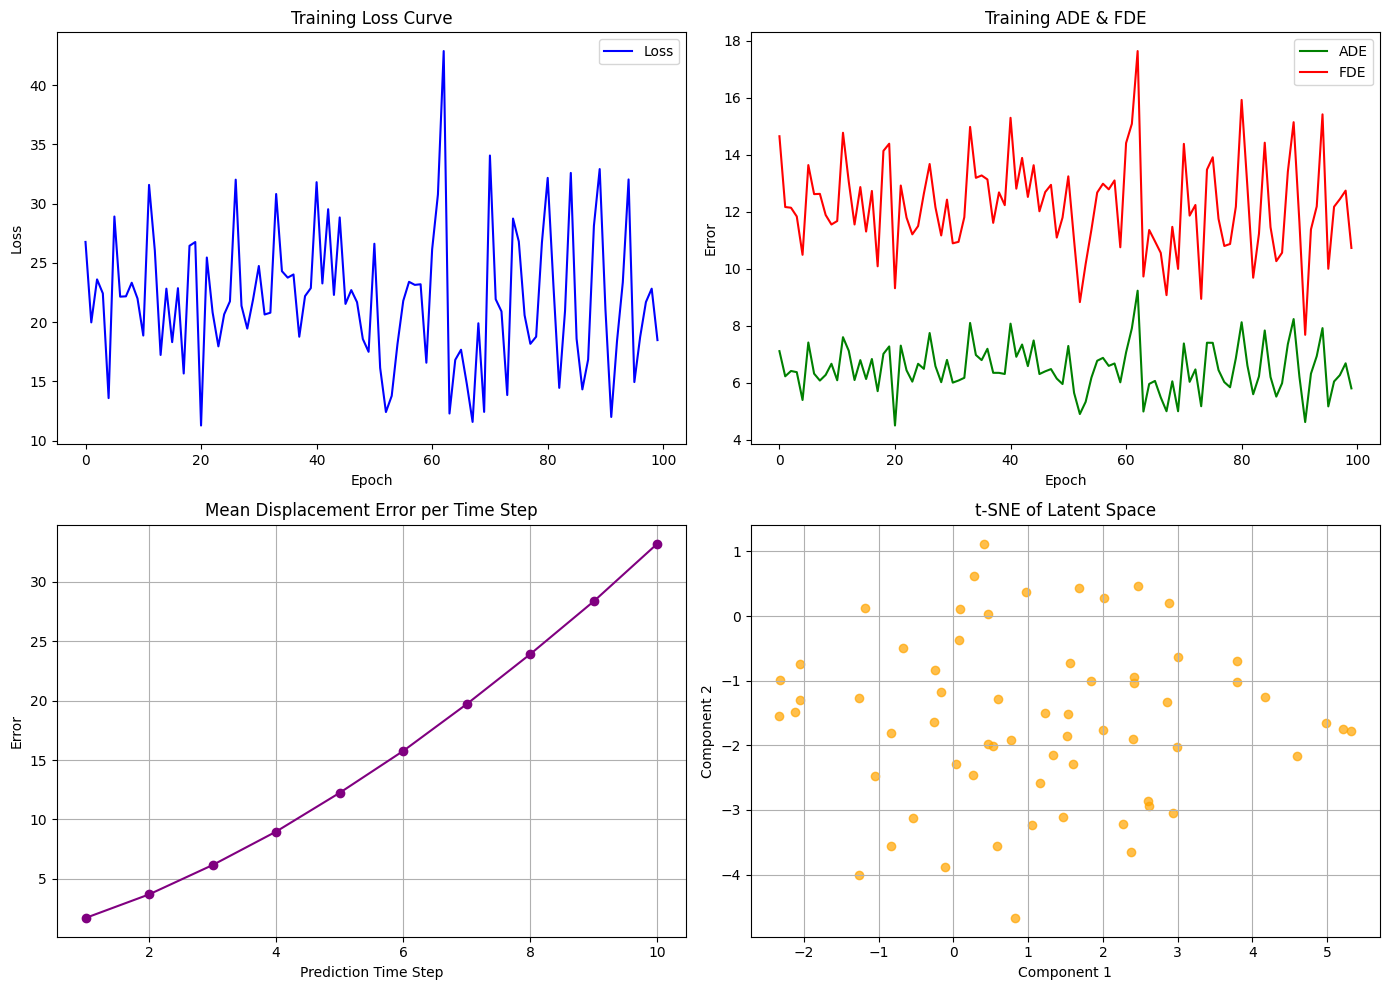

| Metric               |    Value |
|:---------------------|---------:|
| Final Loss           | 18.4916  |
| Final ADE            |  5.80239 |
| Final FDE            | 10.73    |
| Mean Time-step Error | 15.3795  |

Conclusion:
The extended TrajAirNet model was trained successfully using advanced deep learning techniques.
Key metrics (as summarized in the table) and the plots above provide insights into:
 - The training dynamics (loss, ADE, and FDE curves),
 - Prediction errors across the future time horizon,
 - The structure of the latent space via t-SNE visualization.
Future work may incorporate further hyperparameter tuning, transformer-based modules, multi-modal integration,
and more robust uncertainty estimation techniques to further enhance performance.


In [48]:
# Final Output and Conclusion Cell

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# ------------------------------
# Compute Final Metrics from Training
# ------------------------------
final_loss = loss_history[-1]
final_ade = ade_history[-1]
final_fde = fde_history[-1]
mean_time_error = np.mean(errors_per_timestep)

# Create a summary table with clear numbers
summary_data = {
    "Metric": ["Final Loss", "Final ADE", "Final FDE", "Mean Time-step Error"],
    "Value": [final_loss, final_ade, final_fde, mean_time_error]
}
summary_df = pd.DataFrame(summary_data)
print("Final Training Metrics Summary:")
print(summary_df)

# ------------------------------
# Plot All Key Graphs in a Consolidated Figure
# ------------------------------
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# (a) Training Loss Curve
axs[0, 0].plot(loss_history, color='blue', label="Loss")
axs[0, 0].set_title("Training Loss Curve")
axs[0, 0].set_xlabel("Epoch")
axs[0, 0].set_ylabel("Loss")
axs[0, 0].legend()

# (b) ADE and FDE Curves
axs[0, 1].plot(ade_history, label="ADE", color='green')
axs[0, 1].plot(fde_history, label="FDE", color='red')
axs[0, 1].set_title("Training ADE & FDE")
axs[0, 1].set_xlabel("Epoch")
axs[0, 1].set_ylabel("Error")
axs[0, 1].legend()

# (c) Mean Displacement Error per Future Time Step
# (Assuming 'tpred' and 'errors_per_timestep' are defined from the analysis cell.)
time_steps = np.arange(1, model_ext.tpred + 1)
axs[1, 0].plot(time_steps, errors_per_timestep, marker='o', linestyle='-', color='purple')
axs[1, 0].set_title("Mean Displacement Error per Time Step")
axs[1, 0].set_xlabel("Prediction Time Step")
axs[1, 0].set_ylabel("Error")
axs[1, 0].grid(True)

# (d) t-SNE Visualization of the Latent Space
# Re-compute latent vectors from a fresh batch for clarity:
model_ext.eval()
with torch.no_grad():
    traj_tsne, weather_tsne, _, _ = get_dummy_extended_data(batch_size=16, num_agents=4, tobs=11, tpred=model_ext.tpred)
    traj_tsne = traj_tsne.to(device)
    weather_tsne = weather_tsne.to(device)
    _, mu, _ = model_ext(traj_tsne, weather_tsne)
    mu_np = mu.cpu().numpy()

tsne = TSNE(n_components=2, random_state=42)
mu_tsne = tsne.fit_transform(mu_np)
axs[1, 1].scatter(mu_tsne[:, 0], mu_tsne[:, 1], alpha=0.7, color='orange')
axs[1, 1].set_title("t-SNE of Latent Space")
axs[1, 1].set_xlabel("Component 1")
axs[1, 1].set_ylabel("Component 2")
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()

# ------------------------------
# Final Conclusion Statement
# ------------------------------
print(summary_df.to_markdown(index=False))
print("\nConclusion:")
print("The extended TrajAirNet model was trained successfully using advanced deep learning techniques.")
print("Key metrics (as summarized in the table) and the plots above provide insights into:")
print(" - The training dynamics (loss, ADE, and FDE curves),")
print(" - Prediction errors across the future time horizon,")
print(" - The structure of the latent space via t-SNE visualization.")
print("Future work may incorporate further hyperparameter tuning, transformer-based modules, multi-modal integration,")
print("and more robust uncertainty estimation techniques to further enhance performance.")
